# Map-based simulation for absolute pointing offset with HWP

## Here, we introduce how to assess pointing systematics with HWP by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields
import sbm

# Load the cross-link on the boresight detector

## Input map: CMB (r=0), Gaussian beam smoothing (1 deg for FWHM)


In [2]:
scan_field = ScanFields.load_det("boresight/boresight")
r = 0.0
nside = 128
fiducial_map = sbm.generate_cmb(nside, r, cmb_seed=12345)

fwhm = np.deg2rad(1.0)
input_map = hp.smoothing(fiducial_map, fwhm)
lmax = 3*nside-1
bl = hp.gauss_beam(fwhm, lmax=lmax, pol=True)

# Set a pointing systematics parameter

$\rho$ (`rho`): a magnitude of pointing offset of a dtector.

$\chi$ (`chi`): a pointing offset direction

Here, we set $(\rho, \chi)=(1,0)$ arcmin differential pointing.


In [3]:
I = input_map[0]
P = input_map[1] + 1j*input_map[2]
dI = hp.alm2map_der1(hp.map2alm(input_map[0]), nside=nside)
dQ = hp.alm2map_der1(hp.map2alm(input_map[1]), nside=nside)
dU = hp.alm2map_der1(hp.map2alm(input_map[2]), nside=nside)

eth_I = dI[2] - dI[1]*1j
eth_P = dQ[2] + dU[1] - (dQ[1] - dU[2])*1j
o_eth_P = dQ[2] - dU[1] + 1j*(dQ[1] + dU[2])

rho_T = np.deg2rad(1/60)
chi_T = np.deg2rad(0)

mdim = 3
signal_field = sbm.SignalFields.abs_pointing_field(scan_field, mdim, rho_T, chi_T, I, P, eth_I, eth_P, o_eth_P)

# Solve the liner system

Here, we perform the map-making by 3x3 matrix.


In [4]:
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 3x3 noise covariant matrix are contaminated by the systematics


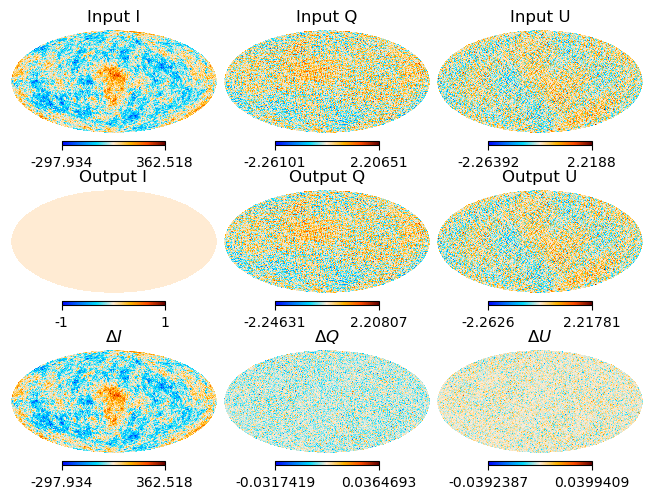

In [5]:
cmap = sbm.get_cmap()
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

# Let's check the power spectra


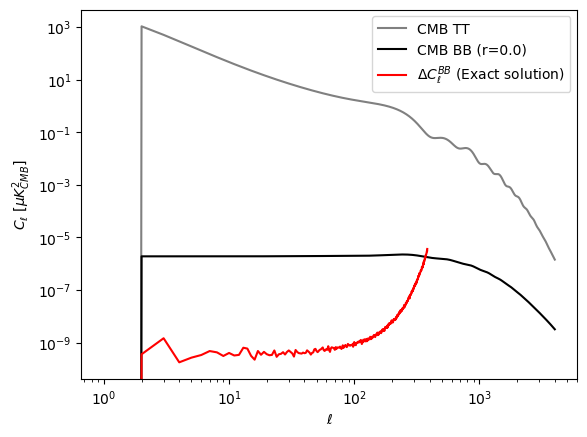

In [6]:
fiducial_cl = sbm.load_fiducial_cl(r)
res_cl = hp.anafast(residual)
delta_cl = res_cl[2] / bl[:,2]**2
ell = np.arange(len(fiducial_cl[0]))

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();

Δr = 5.797737954357588e-07


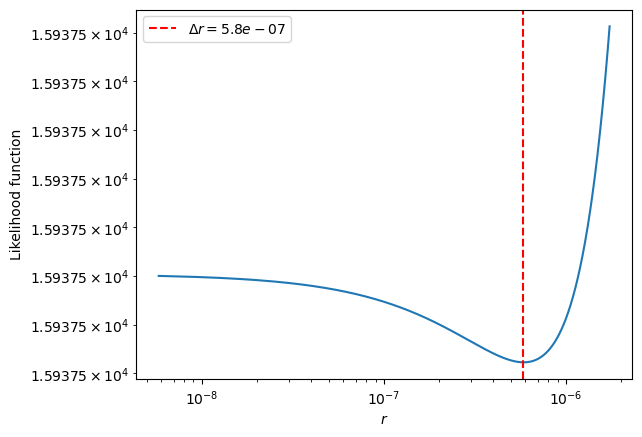

In [7]:
lmax_likelihood = 191
data = sbm.forecast(delta_cl, lmax=lmax_likelihood)
print(f"Δr = {data['delta_r']}")

dr = np.round(data["delta_r"], 9)
plt.plot(data["grid_r"], data["likelihood"], "-")
plt.axvline(data["delta_r"], color="red", label=f"$\Delta r = {dr}$", linestyle="--")
plt.xlabel("$r$")
plt.ylabel("Likelihood function")

plt.yscale("log")
plt.xscale("log")
plt.legend();

# Mitigation method

By chapturing $spin$-$\pm$1 component, we can avoid to have tempereture-to-polarization leakage.
To do it, we expand the matrix size 3x3 to 9x9 as below


In [8]:
mdim = 5
signal_field = sbm.SignalFields.abs_pointing_field(scan_field, mdim, rho_T, chi_T, I, P, eth_I, eth_P, o_eth_P)
output_map = scan_field.map_make(signal_field)
residual = input_map - output_map

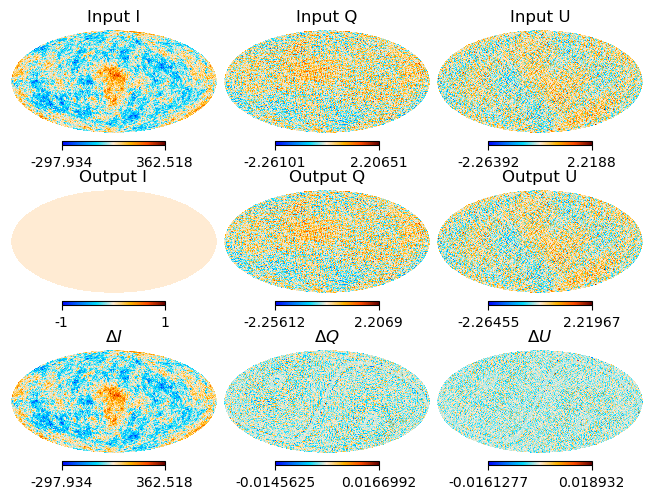

In [9]:
hp.mollview(input_map[0], title="Input I", sub=(3,3,1), cmap=cmap)
hp.mollview(input_map[1], title="Input Q", sub=(3,3,2), cmap=cmap)
hp.mollview(input_map[2], title="Input U", sub=(3,3,3), cmap=cmap)

# SBM does not reconstruct I if `only_iqu`` is True
hp.mollview(output_map[0], title="Output I", sub=(3,3,4), cmap=cmap)
hp.mollview(output_map[1], title="Output Q", sub=(3,3,5), cmap=cmap)
hp.mollview(output_map[2], title="Output U", sub=(3,3,6), cmap=cmap)

hp.mollview(residual[0], title="$\Delta I$", sub=(3,3,7), cmap=cmap)
hp.mollview(residual[1], title="$\Delta Q$", sub=(3,3,8), cmap=cmap)
hp.mollview(residual[2], title="$\Delta U$", sub=(3,3,9), cmap=cmap)

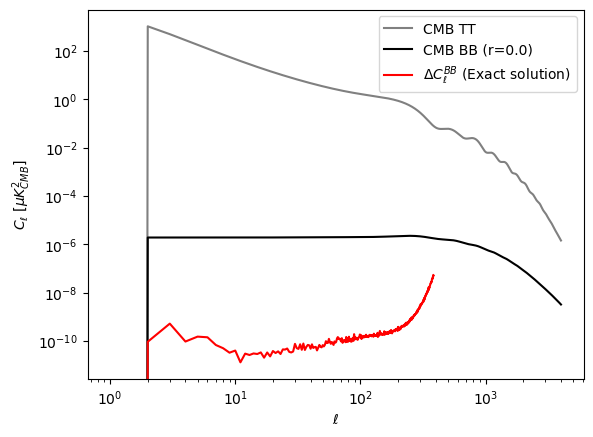

In [12]:
res_cl = hp.anafast(residual)
delta_cl = res_cl[2] / bl[:,2]**2

ell = np.arange(len(fiducial_cl[0]))

plt.plot(fiducial_cl[0], label="CMB TT", color="gray")
plt.plot(fiducial_cl[2], label=f"CMB BB (r={r})", color="black")
plt.plot(res_cl[2] / bl[:,2]**2, label="$\Delta C_\ell^{BB}$ (Exact solution)", color="red") # deconvolution

plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K_{CMB}^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();

Δr = 8.8657559863726e-08


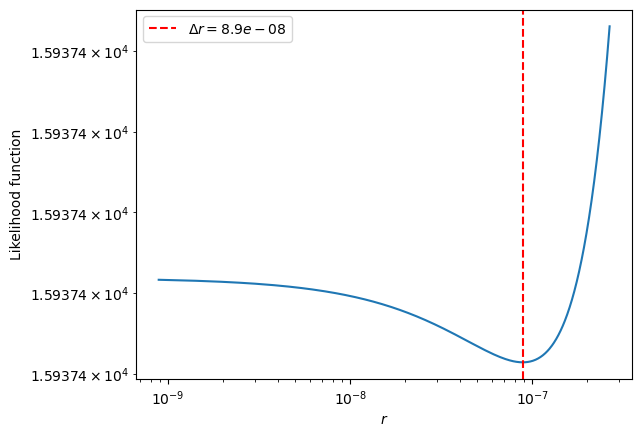

In [11]:
data = sbm.forecast(delta_cl, lmax=lmax_likelihood)

print(f"Δr = {data['delta_r']}")

dr = np.round(data["delta_r"], 9)
plt.plot(data["grid_r"], data["likelihood"], "-")
plt.axvline(data["delta_r"], color="red", label=f"$\Delta r = {dr}$", linestyle="--")
plt.xlabel("$r$")
plt.ylabel("Likelihood function")

plt.yscale("log")
plt.xscale("log")
plt.legend();